# Tutorial for *BiLO: Bi-Level Local Operator for PDE inverse problem*

### using NVIDIA/physicssnemo

### PDE Inverse Problem
We are interested in solving the following PDE constrained optimization problem:
$$
\begin{aligned}
& \min_{\theta} L_{data} = \sum_{i=1}^n(u(x_i) - u_{\text{obs}}(x_i))^2\\
& \text{s.t.   } F(D^ku, ... , D^ku, \theta) = 0
\end{aligned}
$$

where $u$ is the solution of the PDE, $u_{\text{obs}}$ is the observed data, $F$ is the PDE operator, and $\theta$ is the PDE parameter, such as the diffusion coefficient, production rate, etc.

### Bilevel Local Operator Learning

Suppose we have the full PDE solution operator $u(x,\theta)$, which solve the PDE for any given parameter $\theta$. Then the problem becomes an unconstrained optimization problem in the PDE parameter space, and we can use gradient based optimization methods to solve it. 

However, in practice, we usually don't have the full PDE solution operator, and in order to approximate the gradient of the loss function with respect to the PDE parameter, we only need the solution operator locally for a small neighborhood of the current parameter $\theta$. This translates to the condition 

- residual at $\theta$ is 0, $F(D^ku, ... , D^ku, \theta) = 0$
- derivate of the residual with respect to the PDE parameter $\theta$ is 0 $\nabla_{\theta} F(D^ku, ... , D^ku, \theta) = 0$

We can approximate local solution operator by a neural network u(x, $\theta$; W), where W are the weights of the neural network. And the 2 conditions above can be written as residual loss $L_{res}$ and residual gradient loss $L_{resgrad}$:

We can solve the following bi-level optimization problem to approximate the gradient of the loss function with respect to the PDE parameter $\theta$:

$$
\begin{aligned}
& \min_{\theta} L_{data}(\theta, W^*(\theta))\\
& W^*(\theta) = \arg\min_{W} L_{res}(W, \theta) + L_{resgrad}(W, \theta)
\end{aligned}
$$

For details discussion, please refer to the original paper.



## Implementation of BiLO using physicssnemo

In this example, we solve the inverse problem using BiLO

$$
\begin{aligned}
& \min_{u} \sum_{i=1}^n(u(x_i) - u_{\text{obs}}(x_i))^2\\
& \text{s.t.   }\quad D u'' = f, \quad u(0) = 0, \quad u(1) = 0,
\end{aligned}
$$

where $u_{\text{obs}}$ is the observed data, $u$ is the solution, and $f = - \pi^2 \sin(\pi x)$. $D$ is an unknown parameter. In this example, the full solution operator is $u(x,D) = \sin(\pi x)/D$


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import math

from sympy import Symbol, Function, Number, sin, pi

import physicsnemo.sym
from physicsnemo.sym.key import Key
from physicsnemo.sym.node import Node
from physicsnemo.sym.graph import Graph

from physicsnemo.sym.eq.pde import PDE
from physicsnemo.sym.models.fully_connected import FullyConnectedArch

/home/ziruz16/.conda/envs/torch2/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ziruz16/.conda/envs/torch2/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/ziruz16/.conda/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# convert a function to a torch module, which is required by Node.evaluate
class LambdaModule(torch.nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

# 1D Poisson equation example. Compute residual and residual gradient w.r.t. D.
class PoissonEquation1D(PDE):
    name = "PoissonEquation1D"

    def __init__(self):
        # define symbols
        x = Symbol("x")
        D = Symbol("D")

        # input variables dictionary
        input_variables = {"x": x, "D": D}

        # define u as a function of input_variables
        u = Function("u")(*input_variables)

        self.equations = {}
        self.equations["res"] = D * u.diff(x, 2) + (pi**2 * sin(pi * x))
        self.equations["resgrad"] = self.equations["res"].diff(D,1)

equation = PoissonEquation1D()

# Define the neural network architecture
net = FullyConnectedArch(
    input_keys=[Key("x"), Key("D")],
    output_keys=[Key("u_net")],
    nr_layers=3,
    layer_size=64
)

# This transformation node produces u(x) = x*(1-x)*u_net to enforce the boundary conditions
transform = lambda input_vars:  {'u':input_vars["x"] * (1 - input_vars["x"]) * input_vars["u_net"]}

net_transform = Node(
    name="bc_transform",
    inputs=["u_net", "x"],
    outputs=["u"],
    evaluate=LambdaModule(transform),
)

We first train BiLO with initial guess $D_0 = 1$, that is , we only solve the lower level problem of minimizing residual loss and residual gradient loss.

In [ ]:
# Define the scalar PDE parameter D
D = torch.nn.Parameter(torch.tensor(1.0, dtype=torch.float32))

# This is a simple lambda function that expands D to the same batch dimension as x, 
# which is required when computing the residual gradient
expand = lambda input_vars: {"D": input_vars['D_scalar'].expand_as(input_vars["x"])}
expand_node = Node(
    name="expand_node",
    inputs=["x","D_scalar"],
    outputs=["D"],
    evaluate=LambdaModule(expand),
)

# Define the loss function
loss_function = lambda invar: {
    "res_loss": torch.mean(invar["res"]**2),
    "resgrad_loss": torch.mean(invar["resgrad"]**2),
    "total_loss": torch.mean(invar["res"]**2) + torch.mean(invar["resgrad"]**2),
}

loss_node = Node(
    name="loss_node",
    inputs=["res", "resgrad"],
    outputs=["total_loss", "res_loss", "resgrad_loss"],
    evaluate=LambdaModule(loss_function),
)

# All the nodes for pretraining
nodes = (
    [net.make_node(name="network")] +
    equation.make_nodes() +  # This now uses u computed in previous node(s)
    [net_transform] +
    [loss_node] +
    [expand_node]
)

# Graph for pretraining
graph = Graph(
    nodes=nodes,
    invar=[Key("x"), Key("D_scalar")],
    req_names=[Key("total_loss"), Key("res_loss"), Key("resgrad_loss"), Key("u")]
)


optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Generate colloction points for residual loss
x = torch.linspace(0, 1, 100).reshape(-1, 1).requires_grad_(True)

num_steps = 1000
for step in range(num_steps):
    optimizer.zero_grad()  # Clear gradients

    # Forward pass through the graph. Graph.forward converts x from numpy to torch internally.
    output = graph.forward({"x": x, "D_scalar": D})
    loss = output["total_loss"]
    loss.backward()        # Backward pass
    optimizer.step()       # Update parameters

    if step % 100 == 0:
        print(
            f"step {step}: D = {D.item()}, Loss = {loss.item()}, Residual Loss = {output['res_loss'].item()}, Residual Gradient Loss = {output['resgrad_loss'].item()}"
        )


/home/ziruz16/.conda/envs/torch2/lib/python3.11/site-packages/physicsnemo/sym/eq/derivatives.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Epoch 0: D = 1.0, Loss = 49.04619598388672, Residual Loss = 49.02158737182617, Residual Gradient Loss = 0.024607067927718163
Epoch 100: D = 1.0, Loss = 0.13366807997226715, Residual Loss = 0.08342024683952332, Residual Gradient Loss = 0.050247836858034134
Epoch 200: D = 1.0, Loss = 0.025429120287299156, Residual Loss = 0.017540019005537033, Residual Gradient Loss = 0.007889101281762123
Epoch 300: D = 1.0, Loss = 0.01659073494374752, Residual Loss = 0.012592512182891369, Residual Gradient Loss = 0.003998222295194864
Epoch 400: D = 1.0, Loss = 0.01275679748505354, Residual Loss = 0.009350519627332687, Residual Gradient Loss = 0.003406277857720852
Epoch 500: D = 1.0, Loss = 0.02473451755940914, Residual Loss = 0.010291960090398788, Residual Gradient Loss = 0.014442557469010353
Epoch 600: D = 1.0, Loss = 0.004707750864326954, Residual Loss = 0.00422950042411685, Residual Gradient Loss = 0.00047825061483308673
Epoch 700: D = 1.0, Loss = 0.0032964362762868404, Residual Loss = 0.0028613554313

### Visualizing BILO

After pre-training at $D_0$, we can evaluate the local operator at its neighborhood $D_0 + \Delta$.
Because of the residual-gradient loss, the local operator is able to approximate the true PDE solution at the neighborhood $D_0 + \Delta$

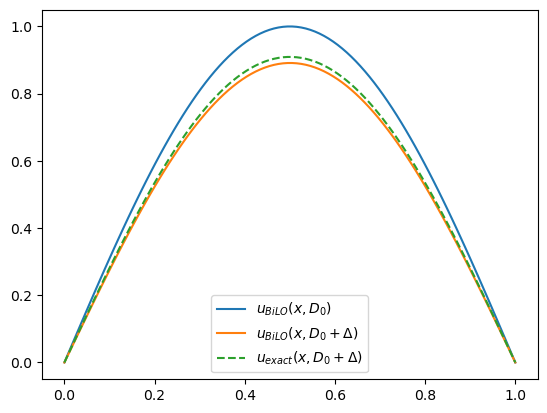

In [4]:
# Define the exact solution, u(x,D) = sin(pi*x)/D
exact_solution = lambda input_vars: {"u_exact": torch.sin(math.pi * input_vars["x"])/input_vars["D_scalar"]}

exact_solution_node = Node(
    name="exact_solution",
    inputs=["x", "D_scalar"],
    outputs=["u_exact"],
    evaluate=LambdaModule(exact_solution),
)

# Graph for evaluation only, no need to compute gradients
graph_eval = Graph(
    nodes=[net.make_node(name="network"), net_transform, expand_node, exact_solution_node],
    invar=[Key("x"), Key("D_scalar")],
    req_names=[Key("u"), Key("u_exact")]
)

# plot u(x)
with torch.no_grad():
    D0 = torch.tensor(1.0)
    x = torch.linspace(0, 1, 100).reshape(-1, 1)
    output = graph_eval.forward({"x": x, "D_scalar": D0})
    u = output["u"].detach().numpy()
    u_exact = output["u_exact"].detach().numpy()

    delta = 0.1
    output_neighbor = graph_eval.forward({"x": x, "D_scalar": D0 + delta})
    u_neighbor = output_neighbor["u"].detach().numpy()
    u_neighbor_exact = output_neighbor["u_exact"].detach().numpy()

    x.detach().numpy()
    plt.plot(x, u, label="$u_{BiLO}(x,D_0)$")
    # plt.plot(x, u_exact, label="u_exact at D=1", linestyle='--')
    plt.plot(x, u_neighbor, label="$u_{BiLO}(x,D_0+\Delta)$")
    plt.plot(x, u_neighbor_exact, label="$u_{exact}(x,D_0+\Delta)$", linestyle='--')

    plt.legend()
    plt.show()

Next, we solve the inverse problem with the noisy data to infer D.

In [ ]:
# need data loss for inverse problem
# u_data will be the observed data of u
inverse_loss = lambda invar: {
    "data_loss": torch.mean((invar["u_data"] - invar["u"])**2),
    "res_loss": torch.mean(invar["res"]**2),
    "resgrad_loss": torch.mean(invar["resgrad"]**2),
}

inverse_loss_node = Node(
    name="inverse_loss_node",
    inputs=["u_data", "u", "res", "resgrad"],
    outputs=["data_loss", "res_loss", "resgrad_loss"],
    evaluate=LambdaModule(inverse_loss),
)

inverse_nodes = ([net.make_node(name="network")] +
    equation.make_nodes() +  # This now uses u computed in previous node(s)
    [net_transform] +
    [inverse_loss_node] +
    [expand_node])

# Graph for inverse problem
graph_inv = Graph(
    nodes= inverse_nodes,
    invar=[Key("x"), Key("D_scalar"), Key("u_data")],
    req_names=[Key("data_loss"), Key("res_loss"), Key("resgrad_loss")]
)


# Generate training data using ground truth D_gt = 2.0
D_gt = torch.tensor(2.0)
x = torch.linspace(0, 1, 10).reshape(-1, 1)
u_data = torch.sin(math.pi * x)/D_gt + 0.01 * torch.randn_like(x)
x.requires_grad_(True)

# lower level parameters, W of the neural network
param_net = list(net.parameters())

# upper level parameters, pde parameter D
param_pde = [D]

# optimizer for the lower level
optimizer_net = torch.optim.Adam(param_net, lr=0.001)

# optimizer for the upper level
optimizer_pde = torch.optim.Adam(param_pde, lr=0.002)


num_steps = 2000
for step in range(num_steps):
    optimizer_net.zero_grad()
    optimizer_pde.zero_grad()

    # Forward pass through the graph
    output = graph_inv.forward({"x": x, "D_scalar": D, "u_data": u_data})
    
    # compute gradients of data loss w.r.t. D
    output['data_loss'].backward(inputs=param_pde, retain_graph=True)
    
    # compute gradients of residual and residual gradient loss w.r.t. W
    lower_loss = output['res_loss'] + output['resgrad_loss']
    lower_loss.backward(inputs=param_net, retain_graph=True)
    
    optimizer_pde.step()
    optimizer_net.step()

    if step % 100 == 0:
        print(
            f"step {step}: D = {D.item()}, data = {output['data_loss'].item()}, res = {output['res_loss'].item()}, resgrad = {output['resgrad_loss'].item()}"
        )


Epoch 0: D = 1.0019999742507935, data = 0.10593900829553604, res = 0.0018284795805811882, resgrad = 0.0010062973015010357
Epoch 100: D = 1.1771053075790405, data = 0.05226781219244003, res = 0.0030488488264381886, resgrad = 0.002048428636044264
Epoch 200: D = 1.3018079996109009, data = 0.02932187356054783, res = 0.0007935360772535205, resgrad = 0.0006705549312755466
Epoch 300: D = 1.3992106914520264, data = 0.018079157918691635, res = 0.0006495253765024245, resgrad = 0.00046471779933199286
Epoch 400: D = 1.4789161682128906, data = 0.011740902438759804, res = 0.0004816644359380007, resgrad = 0.0004909341805614531
Epoch 500: D = 1.545674204826355, data = 0.008020895533263683, res = 0.0003136544837616384, resgrad = 0.00034867896465584636
Epoch 600: D = 1.602430820465088, data = 0.005574989132583141, res = 0.0004709565546363592, resgrad = 0.0006797509267926216
Epoch 700: D = 1.6511722803115845, data = 0.00393294170498848, res = 0.000755791028495878, resgrad = 0.0010958368657156825
Epoch 80

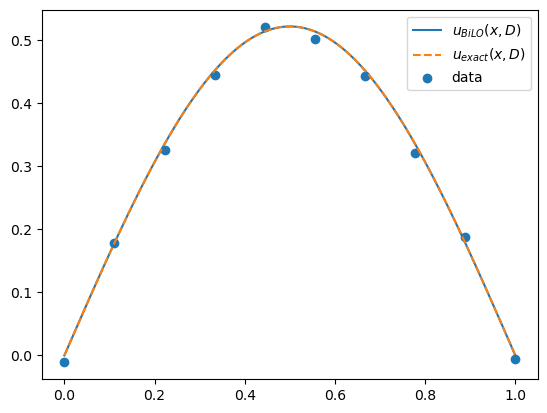

In [ ]:
# visualize the results
with torch.no_grad():
    x_test = torch.linspace(0, 1, 100).reshape(-1, 1)
    output = graph_eval.forward({"x": x_test, "D_scalar": D})
    u = output["u"].detach().numpy()
    u_exact = output["u_exact"].detach().numpy()

    
    plt.plot(x_test, u, label="$u_{BiLO}(x,D)$")
    plt.plot(x_test, u_exact, label="$u_{exact}(x,D)$", linestyle='--')
    plt.scatter(x, u_data, label="data")
    

    plt.legend()
    plt.show()